### 2D Morse wavelet - same as in 1D  
- equation (24) from Metikas & Olhede (2007) 


$\psi_{n;l,m}^{(e)} (f) = \sqrt{2}A_{n;l+1/2,m}(2\pi f)^le^{-(2\pi f)^m} L_n^{c'_{l,m}}(2(2\pi f)^m)$

where $ f = \|\ \mathbf f \|\ $ (defines the wavenumbers in 2D)
- $l = \beta -1/2$
- $\gamma = m$
- $ r = (2 \beta + 1)/\gamma $
- $ A_{n;\beta,\gamma} = \sqrt{\pi \gamma 2^r \Gamma(n+1)/ \Gamma(n+r)} $
- ${c'_{l,m} = (2l+2)/m-1}$
- $ L_n^c(.) $ is the generalised Laguerre polynomial 

#### Aim is to check that 2D Morse recovers:
- correct amplitude of signal
- correct distribution/decay of signal
- directionality (should ntot be recovered given that wavelet is isotropic)
- inverse (reconstruction) of WT should give back original signal


#### Update in notebook:
- inlcude lines/conditions for when beta=0


In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from scipy import signal
from scipy.special import gammaln,gamma
from math import log, floor, exp

import warnings
warnings.filterwarnings('ignore')

In [2]:
#apply boubdary conditions to data before transform 
#here as zero padding (no detrending of data) - need to implement periodic data 

def zero_pad(x):
    
    #get original length of data
    sizex = np.size(x)
    M=sizex
    
    #get index of first and last value of original data 
    #need to change to account for NaNs in data (e.g where there is topo)
    
    a = 0
    b=len(x)
    
    y = np.zeros(sizex*3)
    
    index=np.arange(a,b)
    indexy= np.arange(M+a-len(index), M + (2*len(index)) + a)
    
    #pad with zeros 
    y[indexy] = np.concatenate((0*x,x,0*x))
    
    return(y)


In [3]:
# compute dimensionless time-domain window width (p) 
def morseprops(ga,be):
    p = np.sqrt(be*ga)
    skew = (ga-3)/p
    kurt = (3-skew)**2 - (2/p**2)
    
    return(p)


In [4]:
#compute modal or peak frequency
def morsefreq(ga,be):  
    if be==0:
        fm = log(2)**(1/ga)
        
    else:
        fm = np.exp((1/ga)*(log(be) - log(ga)))
        
    return(fm)


In [5]:
# compute low frequency cutoff (eqn c3 in Lilly 2017)
def morsespace_low(ga,be,r,N):
    
    p = morseprops(ga,be);
    fmin = (2*np.sqrt(2)*p*r)/N
    
    return(fmin)


In [6]:
# compute highest frequency cutoff
def morsehigh(ga,be,alpha):
    
    N = 10000;
    omhigh = np.linspace(0,np.pi,N)
    
    f = 0*ga
    om = morsefreq(ga,be)*np.pi/omhigh
    
    #use logs to avoid errors for really small gammas
    lnpsi1 = (be/ga) * np.log((exp(1)*ga)/be)
    lnpsi2 = be*np.log(om) - om**ga
    lnpsi = lnpsi1 + lnpsi2
    index = np.argwhere(log(alpha) - lnpsi < 0)[0]

    fmax = omhigh[index]
    
    return(fmax)
    
        

#### Degree of overlap between consecutive wavelet  is defined by D

In [7]:
# generates frequeny array for the generalised Morse array 
# fs has units of radians per sample point (frequency resolution is compatible with the bandwidth)

def morsespace(ga,be,N):
    #using default values as from Lily(2017) for 
    low=(5,N) #5 is packing number (five wavelet footprints span the time series)
    high=(0.1,np.pi)
    D = 4     

    fhigh = min(high[1],morsehigh(ga,be,high[0]))
    flow = max(0,morsespace_low(ga,be,low[0],low[1]))
     
    r = 1 + (1/(D*morseprops(ga,be)))
    N = floor((log(fhigh/flow))/(log(r)))
    fs = fhigh*np.ones((N+1))/(r**np.arange(0,N+1))
    
    return(fs)



In [8]:
#generalised laguerre polynomial 
#as from Olhede and Walden (2002) - gamma function just below eqn (10)
#playing with gamma function properties 
#log of gamma works better apparently in matlab, not sure about python

def laguerre(x,k,c):
    
    for m in np.arange(0,k+1):
        coeff_exp = gammaln(k+c+1) - gammaln(c+m+1) - gammaln(k-m+1);
        fact = np.exp(coeff_exp)
        y = ((-1)**m)*fact*(x**m)/gamma(m+1) 
        
    return(y)
        

In [9]:
#Returns the generalized Morse wavelet amplitude or a-function.

def morseafun(k,ga,be,str):
    
    if str == "ban":
        #amplitude using bandpass normalisation
        om=morsefreq(ga,be)
        a=(2)/(np.exp(be)*np.log(om) - om**ga)
    
    elif str == "ene":
        #amplitude using energy normalisation
        r = (2*be+1)/ga
        a = (2*np.pi*ga*(2**r)*np.exp(gammaln(k) - gammaln(k+r-1)))**0.5

    return(a)


In [10]:
#computes the standard geheralised Morse wavelet (primary wavelet)
#takes in psizero (when omega=0)
def morsewave_first_family(fact,N,K,ga,be,om,psizero,str):
    
    #small k as specified in Lilly (here k=0, when K=1)
    k = K-1
    
    l = be- 0.5
    m = ga
    r = (2*be+1)/ga
    c = (2*l + 2)/(m-1)
    
    L = 0*om
    index = np.arange(0,int(N/2)+1) #only need to take half (something will be flipped after??)

    if str == "ene":
        A = morseafun(k+1,ga,be,str)
        coeff = np.sqrt(1/fact)*A
    
    elif str == "ban":
        if be == 0:
            coeff = 1
        
        else:
            coeff = np.sqrt(exp(gammaln(r)+ gammaln(k+1) - gammaln(k+r)))
        
    L[index] = laguerre(2*om[index]**ga,k,c) 
    psif  = coeff * psizero * L
    
    return(psif)


In [11]:
#computes primary Morse wavelet in frequency domain using equation (10) of Olhede 
#takes in one frequency/scale (fs is scalar) at a time
def morsewave_fs(N,K,ga,be,fs,str):
    l = be - 0.5
    m = ga
    fo = morsefreq(ga,be)
    fact = fs/fo
    om = 2*np.pi*np.linspace(0,1-(1/N),N)/fact

    #compute psizero that should be of length N
    #energy normalisation
    if str == "ene":
        if be == 0:
            psizero = np.exp(-om**m)
        
        else:
            psizero = np.exp(l*np.log(om) - om**m)
        
    #bandpass normalisation 
    elif str == "ban":
        if be == 0:
            psizero = np.exp(-om**ga)
        
        else:
            #calculation for preventing things from blowing up apparently 
            psizero = 2 * np.exp(-be* np.log(fo) + fo**ga + be*np.log(om) - om**ga)
            
    psif_fs = morsewave_first_family(fact,N,K,ga,be,om,psizero,str)
    
    return(psif_fs)

    

In [12]:
#computes primary Morse wavelet in frequency domain using equation (10) of Olhede 
#takes in all scales at a time (fs is an array of scales)
def morsewave(N,K,ga,be,fs,str):
    
    psif = np.zeros((N,np.shape(fs)[0],np.shape(fs)[1]))
    
    for ii in np.arange(np.shape(fs)[0]):
        for jj in np.arange(np.shape(fs)[1]):
        
            psif_fs = morsewave_fs(N,K,ga,be,abs(fs[ii,jj]),str)
            psif[:,ii,jj] = psif_fs
        
    return(psif)


### Create synthetic 2D waves 
- small wavelengths (high wavenumber) that can be resolved
- Investigate different wavelenghts with different spatial variation
- Morse wavelet cannot get out directionality (direction of propagation will not be detected)

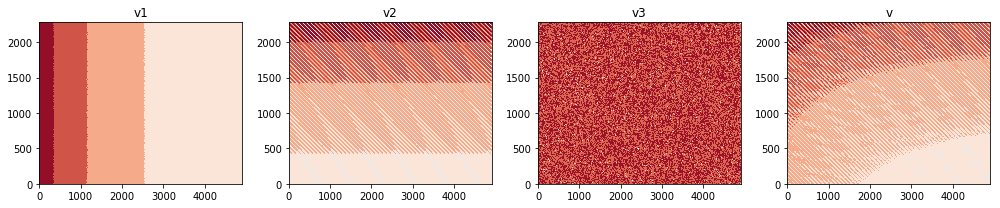

In [13]:
#create synthetic waves 
Nx = 1000
Ny = 500 

phi = 30
phi1 = 25
phi2 = 60
phi3 = phi

#meshgrid as defined from interpolated grid of mitgcm data 
dx = 4913.2902516
dy = 4565.27698988
x = np.arange(0,(Nx*dx),dx)
y = np.arange(0,(Ny*dy),dy)
Y, X = np.meshgrid(y, x)

amp1 = 100
amp2 = 45
amp3 = 1.5 



#from Simmons:
# l >> k ,mode 1 ~ 500km and mode 3 ~ 200km
phi1 = np.radians(phi1)
lam1 = 15e3
k1 = 2*np.pi/lam1
kx1 = k1 * np.cos(phi1)
ky1 = k1 * np.sin(phi1)

phi2 = np.radians(phi2)#angle between wave propagation and x-axis 
lam2 = 50e3
k2 = 2*np.pi/lam2
kx2 = k2 * np.cos(phi2)
ky2 = k2 * np.sin(phi2)

phi3 = np.radians(phi3)#angle between wave propagation and x-axis 
lam3 = 100e3
k3 = 1/lam3
kx3 = k3 * np.cos(phi2)
ky3 = k3 * np.sin(phi2)

#create waves 
v1 = amp1*np.sin(kx1*X + ky1*Y)*np.exp(-5e-7*X)
v2 = amp2*np.sin(kx2*X + ky2*Y)*np.exp(7e-7*Y)
v3 = np.random.rand(Nx,Ny)
v = v1 + v2 + v3

#create figure
fig, ax = plt.subplots(1,4,figsize=(14, 3))
ax[0].contourf(x/1e3,y/1e3,np.transpose(v1),cmap="RdBu_r")
ax[0].set_title("v1")

ax[1].contourf(x/1e3,y/1e3,np.transpose(v2),cmap="RdBu_r")
ax[1].set_title("v2")

ax[2].contourf(x/1e3,y/1e3,np.transpose(v3),cmap="RdBu_r")
ax[2].set_title("v3")

ax[3].contourf(x/1e3,y/1e3,np.transpose(v),cmap="RdBu_r")
ax[3].set_title("v")

plt.tight_layout()
plt.show()

#### blow up of v2 (again directionality will not be detected)

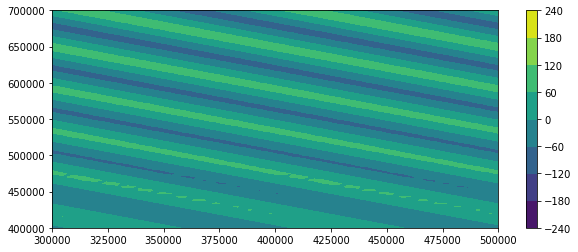

In [14]:
fig, ax = plt.subplots(1,figsize=(10, 4))
plt.contourf(x,y,np.transpose(v2))
plt.xlim(0.3e6,0.5e6)
plt.ylim(0.4e6,0.7e6)
plt.colorbar()
plt.show()

#### Synthetic waves in the wavenumber spectrum

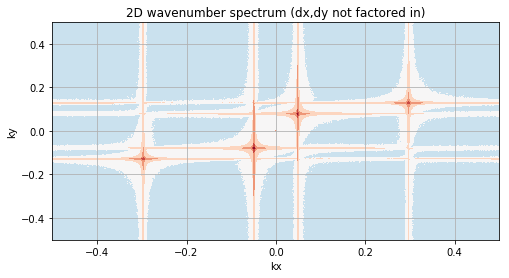

In [25]:
v_fft = np.fft.fft2(v)
v_fft = np.fft.fftshift(v_fft,axes={0,1}) #recentre 0 

fx = np.fft.fftshift(np.fft.fftfreq(Nx)) #returns cycles per unit of sampling (2pi already included) #sampling interval not included here
fy = np.fft.fftshift(np.fft.fftfreq(Ny))


fig, ax = plt.subplots(1,figsize=(8, 4))
plt.contourf(fx,fy,np.transpose(np.log10(v_fft)),cmap="RdBu_r")
plt.grid()
plt.xlabel("kx")
plt.ylabel("ky")
plt.title("2D wavenumber spectrum (dx,dy not factored in)")

plt.show()


### Define wavelet shape and associated frequnecy scales
- $\beta$ controls low freq. behaviour 
- D defines overlap of bandpass filters (in spectral space)
- $\gamma$ controls high freq. decay and symmetry of wavelet
- ***$\gamma$ = 3*** is close to a Gaussian envelope, closest to Morlet shape, highest time-frequency concentration (smallest Heisenberg Area)
- fs computed using Morsespace as from jWavelet package 


*** for non-square areas and unequal sampling
intervals we use the smallest numerical values of Nx and Ny, and of
$\Delta$x and $\Delta$y.***

In [26]:
K=1 # 1: first family of Morse wavelet
ga = 3 #3 ensures symmetry of wavelet
be = 24
str = "ban" #energy normalisation (can also be bandpass)
N = min(Nx,Ny)
#scales (for min and max wavenumber that can be resolved)
fs = morsespace(ga,be,N)
fs =  np.flip(fs,axis=0)


### Form spectral grid on which lies the 2D wavenumber spectrum of the input data

- Here using fftfreq (need to recentre freq/wavenumber=0 using fftshift)
- *** However, fftfreq gives a linear discretisation*** as opposed to the ***function morsespace (used in 1D) which gives a logarithmic discretisation***
- As per Wang (2009) - scales linearly discretised are less efficient numerically
and require extra scaling to achieve perfect
reconstruction.
- note sampling size (dx,dy) not included in ffftfreq 

In [27]:
#meshgrid of fx and fy
FY, FX = np.meshgrid(fy,fx)
grid_fxfy = np.sqrt(FX**2 + FY**2)

#### Wavenumbers that can be resolved (falls outside of ellipse)

- Ellipse defines smallest wavenumber (Rayleigh frequency) that can be resolved by the Morse Wavelet - smallest resolvable freq/wavenumber is defined as per the default value in function morsespace

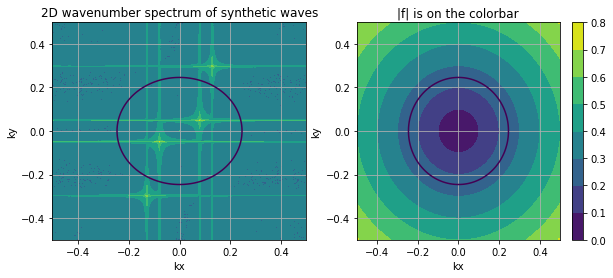

In [28]:
fig, ax = plt.subplots(1,2,figsize=(10, 4))

ax[0].contourf(fy,fx,np.log2(v_fft * np.conj(v_fft)))
ax[0].contour(fy,fx,grid_fxfy,[0,min(fs)])
ax[0].grid()
ax[0].set_title("2D wavenumber spectrum of synthetic waves")
ax[0].set_xlabel("kx")
ax[0].set_ylabel("ky")

fig1 = ax[1].contourf(fy,fx,grid_fxfy)
fig.colorbar(fig1,ax=ax[1])
ax[1].contour(fy,fx,grid_fxfy,[0,min(fs)])
ax[1].grid()
ax[1].set_title("|f| is on the colorbar")
ax[1].set_xlabel("kx")
ax[1].set_ylabel("ky")
plt.show()



*** waves with large wavelength (small wavenumbers) might not be resolved correcltly***

### Computing Morse wavelets as per defined parameters

In [29]:
#use grid_fxfy
N = len(fy) #N is the number of scales available (will depend on fmin and fmax)
psif = morsewave(N,K,ga,be,grid_fxfy,str)

#### If there is any NaN in the computed Morsewave, quick fix is to replace NaN by zero 

In [30]:
#replace NaNs with zeros
psif = np.nan_to_num(psif, copy=True)


### Plot 2D wavelet (in wavenumber domain) at two different scales 

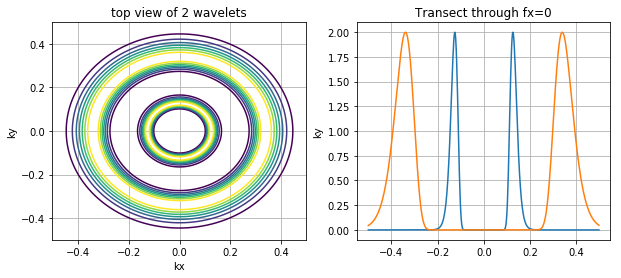

In [31]:
fig, ax = plt.subplots(1,2,figsize=(10, 4))
ss1 = 10
ss2 = 27

ax[0].contour(fy,fx,psif[ss1,:,:])
ax[0].contour(fy,fx,psif[ss2,:,:])
ax[0].grid()
ax[0].set_title("top view of 2 wavelets")
ax[0].set_xlabel("kx")
ax[0].set_ylabel("ky")

ax[1].plot(fy,psif[ss1,499,:])
ax[1].plot(fy,psif[ss2,499,:])
ax[1].grid()
ax[1].set_title("Transect through fx=0")
ax[1].set_ylabel("ky")


plt.show()

### To consider smallest resolvable wavenumber - perform next step 

- smallest resolvable wavenumber defined by: 
        1) min(fs) computed through morsepace or
        2) using 2*(smallest sampling interval)
        
- for wavelet of corresponding scales that are not resolvable (those smaller than the defined threshold) - set wavelet to nan

### Apply wavelet on overall signal (v1 +v2 +v3)
- when computing inverse np.fft.ifft2 should be ordered in the same way as is returned by fft2, i.e. it should have the term for zero frequency in the low-order corner of the two axes

In [32]:
#compute frequency spectrum of data 
v_fft = np.fft.fft2(v,axes=(0,1))
v_fft = np.fft.fftshift(v_fft,axes={0,1}) #recentre 0 

v_wf = np.zeros(np.shape(psif))
for ss in np.arange(np.shape(psif)[0]):
    wt = v_fft * np.conj(psif[ss,:,:])
    wt = np.fft.ifftshift(wt,axes={0,1}) #put back to original space before ifft
    v_wf[ss,:,:] = np.fft.ifft2(wt,axes=(0,1))

### Relating scales to wavelength 
- fx and fy not computed using sampling interval - include in computation here
- finding wavenumber value at peak (max) value of the wavelet in spectral space

In [33]:
#finding fmax? |f| dependent on fx and fy 
# fx and fy did not take into account dx and dy
f_scales = []
for ss in np.arange(np.shape(psif)[0]):
    if ss == 0:
        f = 0
    else:
        ind_max_x, ind_max_y = np.where(psif[ss,:,:] == np.max(psif[ss,:,:]))
        fx_ss = fx[ind_max_x[0]]/dx
        fy_ss = fy[ind_max_y[0]]/dy
        f = np.sqrt(fx_ss**2 + fy_ss**2)
    f_scales.append(f)
        
f_scales = np.array(f_scales)
lambda_scales = 1/f_scales


### Plot out WT corresponding to signal v1
- find closest scale to $\lambda_1$ and plot WT
- factor in $\pi^{-1}$ (some normalisation?) in wavelet transform as per Metikas (2005) - eqn (23)


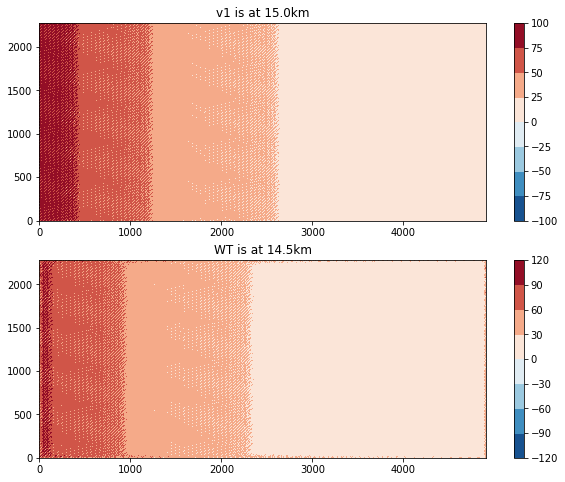

In [34]:
#calculate index closer to defined wavelength
wavelength_sel = lam1
wave_ind = int(np.where(np.abs(lambda_scales - wavelength_sel) == np.min(np.abs(lambda_scales - wavelength_sel)))[0])

fig, ax = plt.subplots(2,1,figsize=(10, 8))

fig0 = ax[0].contourf(x/1e3,y/1e3,np.transpose(v1),cmap="RdBu_r")
fig.colorbar(fig0,ax=ax[0])
ax[0].set_title("v1 is at {}km".format(lam1/1e3))

fig1 = ax[1].contourf(x/1e3,y/1e3,np.transpose(v_wf[wave_ind,:,:]/np.sqrt(np.pi)),cmap="RdBu_r")
fig.colorbar(fig1,ax=ax[1])
ax[1].set_title("WT is at {:.1f}km".format(lambda_scales[wave_ind]/1e3))
plt.show()


-  find closest scale to $\lambda_2$ and plot WT

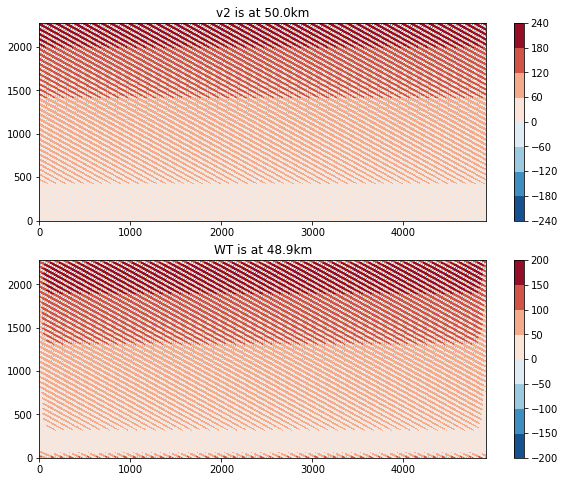

In [35]:
#calculate index closer to defined wavelength
wavelength_sel = lam2
wave_ind = int(np.where(np.abs(lambda_scales - wavelength_sel) == np.min(np.abs(lambda_scales - wavelength_sel)))[0])

fig, ax = plt.subplots(2,1,figsize=(10, 8))

fig0 = ax[0].contourf(x/1e3,y/1e3,np.transpose(v2),cmap="RdBu_r")
fig.colorbar(fig0,ax=ax[0])
ax[0].set_title("v2 is at {}km".format(lam2/1e3))

fig1 = ax[1].contourf(x/1e3,y/1e3,np.transpose(v_wf[wave_ind,:,:]/np.sqrt(np.pi)),cmap="RdBu_r")
fig.colorbar(fig1,ax=ax[1])
ax[1].set_title("WT is at {:.1f}km".format(lambda_scales[wave_ind]/1e3))
plt.show()


*** Remarks ***
- decay structure/distribution of the two individual components recovered correctly
- amplitude of the 2 signals recovered mostly correctly

#### Blow up of filtered v1


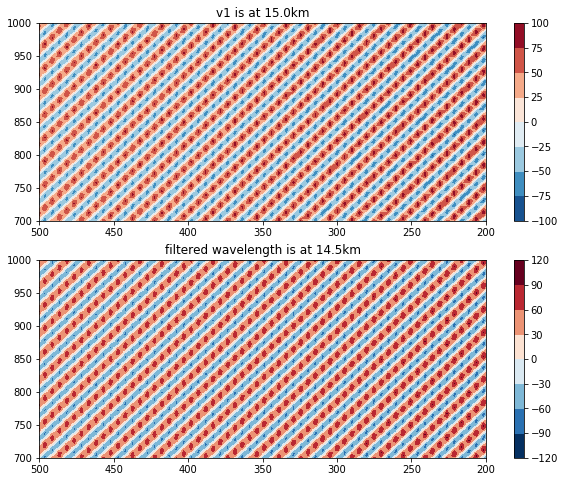

In [36]:
#calculate index closer to defined wavelength
wavelength_sel = lam1
wave_ind = int(np.where(np.abs(lambda_scales - wavelength_sel) == np.min(np.abs(lambda_scales - wavelength_sel)))[0])

fig, ax = plt.subplots(2,1,figsize=(10, 8))

fig0 = ax[0].contourf(x/1e3,y/1e3,np.transpose(v1),cmap="RdBu_r")
fig.colorbar(fig0,ax=ax[0])
ax[0].set_title("v1 is at {}km".format(lam1/1e3))
ax[0].set_xlim(500,200)
ax[0].set_ylim(700,1000)

fig1 = ax[1].contourf(x/1e3,y/1e3,np.transpose(v_wf[wave_ind,:,:]/(np.sqrt(np.pi))),cmap="RdBu_r",vmin=-100,vmax=100)
fig.colorbar(fig1,ax=ax[1])
ax[1].set_title("filtered wavelength is at {:.1f}km".format(lambda_scales[wave_ind]/1e3))
ax[1].set_xlim(500,200)
ax[1].set_ylim(700,1000)

plt.show()


***Remarks***
- direction of propagation also seem to match up

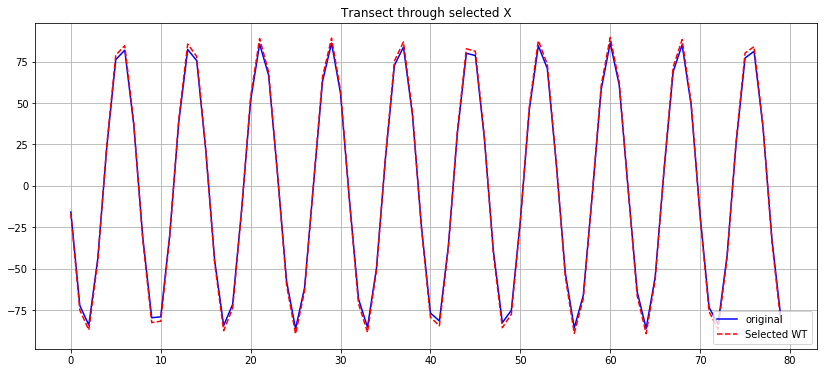

In [37]:
fig, ax = plt.subplots(1,figsize=(14, 6))

plt.plot(v1[60,60:140],color="b",label="original")
plt.plot(v_wf[wave_ind,60,60:140]/(np.sqrt(np.pi)),color="r",linestyle="--",label="Selected WT")
plt.legend(loc="lower right")
plt.title("Transect through selected X")
plt.grid()
plt.show()


#### Test wavelet on single component v2
- apply same set of wavelets on v2_fft


In [38]:
#compute frequency spectrum of data 
v2_fft = np.fft.fft2(v2,axes=(0,1))
v2_fft = np.fft.fftshift(v2_fft,axes={0,1}) #recentre 0 

v2_wf = np.zeros(np.shape(psif))
for ss in np.arange(np.shape(psif)[0]):
    wt = v2_fft * psif[ss,:,:]
    wt = np.fft.ifftshift(wt,axes={0,1})
    v2_wf[ss,:,:] = np.fft.ifft2(wt,axes=(0,1))

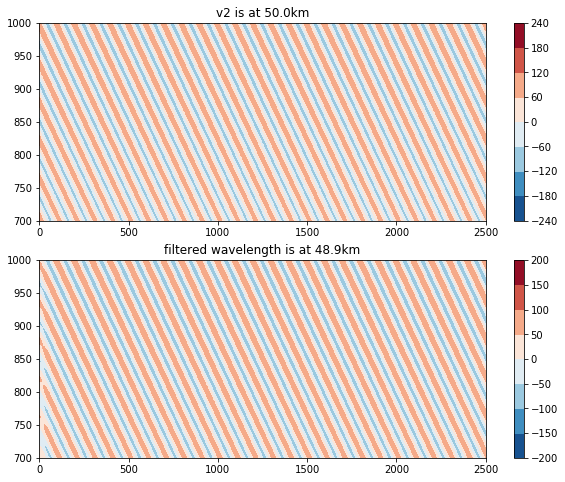

In [39]:
#calculate index closer to defined wavelength
wavelength_sel = lam2
wave_ind = int(np.where(np.abs(lambda_scales - wavelength_sel) == np.min(np.abs(lambda_scales - wavelength_sel)))[0])

fig, ax = plt.subplots(2,1,figsize=(10, 8))

fig0 = ax[0].contourf(x/1e3,y/1e3,np.transpose(v2),cmap="RdBu_r")
fig.colorbar(fig0,ax=ax[0])
ax[0].set_title("v2 is at {}km".format(lam2/1e3))
ax[0].set_xlim(0,2500)
ax[0].set_ylim(700,1000)

fig1 = ax[1].contourf(x/1e3,y/1e3,np.transpose(v2_wf[wave_ind,:,:]/(np.sqrt(np.pi))),cmap="RdBu_r")
fig.colorbar(fig1,ax=ax[1])
ax[1].set_title("filtered wavelength is at {:.1f}km".format(lambda_scales[wave_ind]/1e3))
ax[1].set_xlim(0,2500)
ax[1].set_ylim(700,1000)

plt.show()


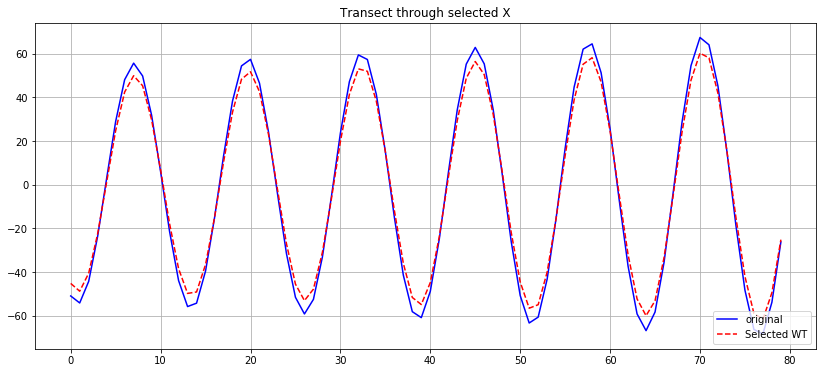

In [40]:
fig, ax = plt.subplots(1,figsize=(14, 6))

plt.plot(v2[60,60:140],color="b",label="original")
plt.plot(v2_wf[wave_ind,60,60:140]/(np.sqrt(np.pi)),color="r",linestyle="--",label="Selected WT")
plt.legend(loc="lower right")
plt.title("Transect through selected X")
plt.grid()
plt.show()


### Reconstruction of wavelet transform (recall that morse is not orthogonal)


#### Inverse formula using the $\delta$ function as the reconstruction wavelt ${\psi'}$ is just the sum of the real part of the wavelet transform over all scales - from Torrence & Compo (1998)

${x_n = \frac{\delta j \delta t^{1/2}}{C_{\delta}\psi_0(0)} \sum_{j=0}^J  \frac{R \{W_n(s_j) \}}{s_j^{1/2} }  }$

- ${\psi_0(0)}$ removes the energy scaling (note time-domain wavelet) - not known analytically for Morse
- ${s_j^{1/2}}$ converts the wavelet transform to an energy density
- $C_\delta$ is the reconstruction factor - not known for Morse


- here calculating the scaling factor: 
$ \frac{\delta j \delta t^{1/2}}{C_{\delta}\psi_0(0)} $ - ratio of max of original signal and max of $\sum_{j=0}^J  \frac{R \{W_n(s_j) \}}{s_j^{1/2} }$

- scaling factor, $ \frac{\delta j \delta t^{1/2}}{C_{\delta}\psi_0(0)} $ defined as $\xi$

- get a regular signal with no decay as input to evaluate $\xi$


In [41]:
# construct signal and plot
v0 = amp2*np.sin(kx2*X + ky2*Y)

# apply wavelet transform
#compute frequency spectrum of data 
v0_fft = np.fft.fft2(v0,axes=(0,1))
v0_fft = np.fft.fftshift(v0_fft,axes={0,1}) #recentre 0 

v0_wf = np.zeros(np.shape(psif))
for ss in np.arange(np.shape(psif)[0]):
    wt0 = v0_fft * np.conj(psif[ss,:,:])
    wt0 = np.fft.ifftshift(wt0,axes={0,1}) #remove recentre
    v0_wf[ss,:,:] = np.fft.ifft2(wt0,axes=(0,1))
    
#reconstruct signal by using delta function for inverse
#dimensions of WT:(fs,x,y)
WT0_sum = (np.real(v0_wf)/(f_scales)**0.5).sum(axis=0)*np.sqrt(np.pi)
scaling_fact = WT0_sum[400:800,200:400]/v0[400:800,200:400] #taking region away from edges 
scaling_fact = np.mean(scaling_fact)
scaling_fact

632.2246201743111

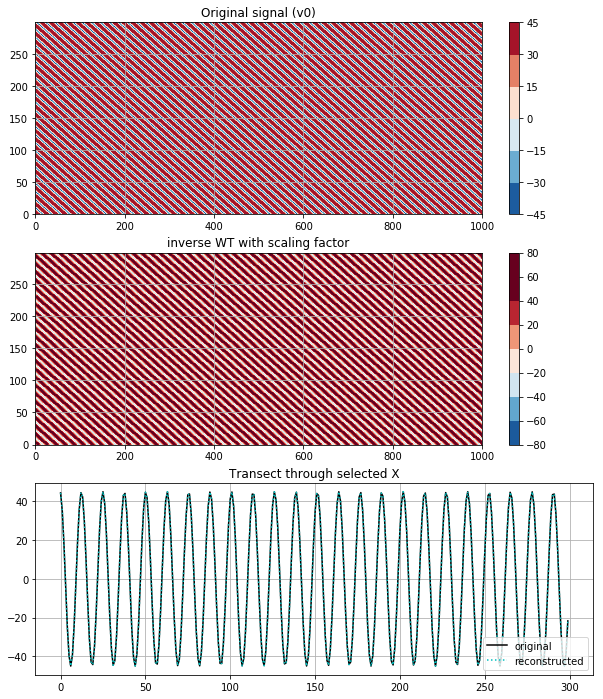

In [42]:
fig, ax = plt.subplots(3,1,figsize=(10, 12))


fig0 = ax[0].contourf(np.transpose(v0[:,100:400]),cmap="RdBu_r")
fig.colorbar(fig0,ax=ax[0])
ax[0].set_title("Original signal (v0)")
ax[0].grid()


fig1 = ax[1].contourf(np.transpose(WT0_sum[:,100:400]/scaling_fact),cmap="RdBu_r",vmax=45)
fig.colorbar(fig1,ax=ax[1])
ax[1].set_title("inverse WT with scaling factor")
ax[1].grid()

ax[2].plot(v0[150,100:400],color="k",label="original")
ax[2].plot(WT0_sum[150,100:400]/scaling_fact,linestyle=":",color="c",label="reconstructed")
ax[2].set_title("Transect through selected X")
ax[2].legend(loc="lower right")
ax[2].grid()


plt.show()

### Using computed scaling factor to recover signal v

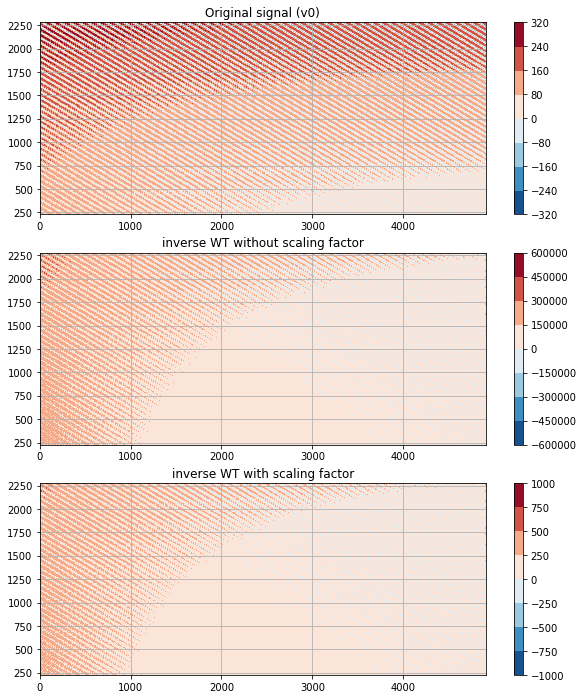

In [58]:
#dimensions of WT:(fs,x,y)
WT_sum = (np.real(v_wf)/(f_scales)**0.5).sum(axis=0)*np.sqrt(np.pi)
fig, ax = plt.subplots(3,1,figsize=(10, 12))


fig0 = ax[0].contourf(x/1e3,y[50:500]/1e3,np.transpose(v[:,50:500]),cmap="RdBu_r")
fig.colorbar(fig0,ax=ax[0])
ax[0].set_title("Original signal (v0)")
ax[0].grid()


fig1 = ax[1].contourf(x/1e3,y[50:500]/1e3,np.transpose(WT_sum[:,50:500]),cmap="RdBu_r")
fig.colorbar(fig1,ax=ax[1])
ax[1].set_title("inverse WT without scaling factor")
ax[1].grid()


fig2 = ax[2].contourf(x/1e3,y[50:500]/1e3,np.transpose(WT_sum[:,50:500]/scaling_fact),cmap="RdBu_r")
fig.colorbar(fig2,ax=ax[2])
ax[2].set_title("inverse WT with scaling factor")
ax[2].grid()

plt.show()

#### Transect through selected X

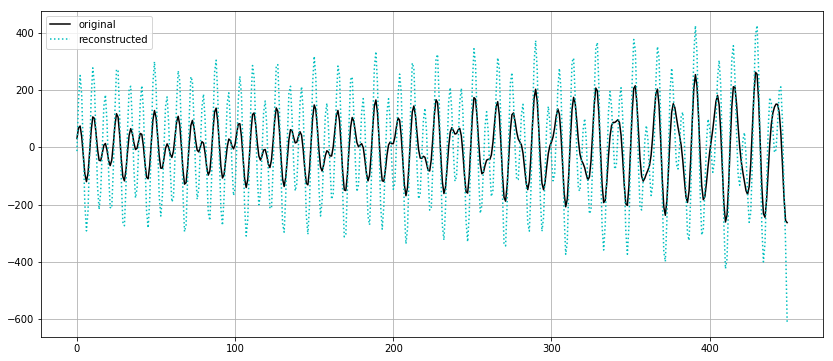

In [67]:
fig, ax = plt.subplots(1,figsize=(14, 6))
plt.plot(v[150,50:500],color="k",label="original")
plt.plot(WT_sum[150,50:500]/scaling_fact,linestyle=":",color="c",label="reconstructed")
plt.legend(loc="bottom right")
plt.grid()
plt.show()

***Remarks***
- Reconstruction of signal with reconstruction factor does not work
- possibly due to normalisation in $\sum_{j=0}^J  \frac{R \{W_n(s_j) \}}{s_j^{1/2}} $ where $s_j$ represents the scales (weight given to individual WT wrong), here using the frequency_scales instead or reconstruction might break because the scales are linearly discretised (reconstruction only works with logarithmic discretisation)


### Things to do:
